In [1]:
import torch
import pandas as pd, numpy as np, matplotlib, matplotlib.pyplot as plt
from torch import nn
from torch.nn import init
from torch.autograd import Variable

In [2]:
import torchvision


In [27]:
data = torchvision.datasets.MNIST(root='.', download=True)
train_data = data.train_data.numpy().reshape(60000, -1)
train_labels = data.train_labels.numpy().reshape(60000, -1)

data_test = torchvision.datasets.MNIST(root='.', download=True, train=False)
test_data = data_test.test_data.numpy().reshape(10000, -1)
test_labels = data_test.test_labels.numpy().reshape(10000, -1)

data = np.concatenate([train_data, test_data], axis=0)
labels = np.concatenate([train_labels, test_labels], axis=0)
labels = (labels > 4).astype(float)
data = np.concatenate([data, labels], axis=1)

data.shape

(70000, 785)

In [28]:
#df = pd.read_csv('diabetic_data.csv')

In [41]:
pandas = 0
if pandas:
    one_hot = ['gender', 'race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 
               'metformin', 'repaglinide', 'nateglinide',
               'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
               'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
               'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
               'insulin', 'glyburide-metformin', 'glipizide-metformin',
               'glimepiride-pioglitazone', 'metformin-rosiglitazone',
               'metformin-pioglitazone', 'change', 'diabetesMed',
               'A1Cresult','max_glu_serum']
    numeric = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
               'num_medications', 'number_outpatient', 'number_emergency',
               'number_inpatient', 'number_diagnoses',
               'diag_1', 'diag_2', 'diag_3']
    first_numeric = ['age']
    norm_and_none_and_numeric = ['A1Cresult','max_glu_serum']
    numeric_but_confused_about_V_and_E_values = ['diag_1', 'diag_2', 'diag_3', ]
    latent = ['patient_nbr']

    use_latent = False
    Toss_null = True
    if Toss_null:
        #Throw away columns with too many nulls, throw away rows with nulls afterwards
        df = df.loc[:,df.isin(['?']).sum(0) < 15000]
        df = df.loc[df.isin(['?']).sum(1) < 1,:]
    df = df.astype(str)
    data = df.loc[:,'readmitted']
    data = data.str.replace('NO', '0').replace('>30', '1').replace('<30', '1').astype(float)
    for col in one_hot:
        new_data = df.loc[:,col]
        if new_data.unique().shape[0] < 2:
            continue
        if new_data.unique().shape[0] < 3:
            new_data = (new_data == new_data.unique()[0]).astype(float)
        else:
            new_data = pd.get_dummies(new_data)
        data = pd.concat((data, new_data), 1)
    for col in numeric:
        new_data = df.loc[:,col].astype(str)
        new_data = new_data.str.replace('None', '0').str.replace('>', '').str.replace('<', '').astype(float)
        data = pd.concat((data, new_data), 1)
    for col in first_numeric:
        new_data = df.loc[:,col].astype(str)
        new_data = new_data.str[1:3].str.replace('-','').astype(float)
        data = pd.concat((data, new_data), 1)
    #Convert data pandas to numpy
    data = data.as_matrix()

In [32]:
#Check the final shape of our in-use dataset
print('data shape', data.shape)

#Feature shapes
num_rows, num_features = data.shape[0], data.shape[1]-1

#Select Training rows
np.random.seed(0)
trn_rows = np.sort(np.random.choice(num_rows, size = int(num_rows * .9), replace = False))

#Select Validation rows
val_rows = np.setdiff1d(np.arange(num_rows), trn_rows)

#Split dataset
trn_data, val_data = data[trn_rows,:-1], data[val_rows,:-1]
trn_Y, val_Y = data[trn_rows,-1], data[val_rows,-1]

#Normalize training and validation based on training data
data_mean, data_std = trn_data.mean(0), trn_data.std(0) + 1e-8

def normalize_data(data, data_mean, data_std):
    normalized = (data - np.expand_dims(data_mean,0)) / np.expand_dims(data_std,0)
    return normalized

trn_normalized = normalize_data(trn_data, data_mean, data_std)
val_normalized = normalize_data(val_data, data_mean, data_std)

data shape (70000, 785)


In [33]:
# Code to cleanly swap between Pytorch and Numpy.
# Makes PyTorch much more user friendly, but not widely used. 
# Base code from Andy Gan (Github BarclayII) with some minor additions

#Main adjustable flag. Enables or Disable GPU optimizations
USE_CUDA = 1

def cuda(obj):
    if USE_CUDA:
        if isinstance(obj, tuple):
            return tuple(cuda(o) for o in obj)
        elif isinstance(obj, list):
            return list(cuda(o) for o in obj)
        elif hasattr(obj, 'cuda'):
            return obj.cuda()
    return obj

def tovar(*arrs, **kwargs):
    tensors = [(torch.from_numpy(a) if isinstance(a, np.ndarray) else a) for a in arrs]
    vars_ = [torch.autograd.Variable(t, **kwargs) for t in tensors]
    if USE_CUDA:
        vars_ = [v.cuda() for v in vars_]
    return vars_[0] if len(vars_) == 1 else vars_


def tonumpy(*vars_):
    arrs = [(v.data.cpu().numpy() if isinstance(v, torch.autograd.Variable) else
             v.cpu().numpy() if torch.is_tensor(v) else v) for v in vars_]
    return arrs[0] if len(arrs) == 1 else arrs

In [34]:
#Build the network in pytorch

def init_weights(module):
    for name, param in module.named_parameters():
        if name.find('weight') != -1:
            if len(param.size()) == 1:
                init.uniform(param.data, 1)
            else:
                init.xavier_uniform(param.data)
        elif name.find('bias') != -1:
            init.constant(param.data, 0)

class Identity(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)

    def forward(self, x):
        return x

class Model(nn.Module):
    def __init__(self,num_inputs, hidden_layers, output_fcn = None, lr = 1e-3, polynomial_features = False):
        #num_inputs is the number of input feature
        #Hidden layers is a list of hidden layer sizes)
        #output_fcn should be either 'linear' or 'logistic'
        nn.Module.__init__(self)
        self.num_inputs = num_inputs
        self.output_type = output_fcn
        
        prev_out_size = num_inputs
        self.hidden_layers = nn.ModuleList()
        
        self.trn_losses = []
        self.val_losses = []
        self.trn_accs = []
        self.val_accs = []
        self.relu = nn.LeakyReLU()
        self.polynomial_features = polynomial_features
        if polynomial_features:
            prev_out_size = prev_out_size ** 2
        for l in hidden_layers:
            self.hidden_layers.append(nn.Linear(prev_out_size, l))
            prev_out_size = l
        self.output_layer = nn.Linear(prev_out_size, 1)
        
        if output_fcn == 'linear':
            self.output_fcn = Identity()
            self.loss_fcn = nn.MSELoss()
        elif output_fcn == 'logistic':
            self.output_fcn = nn.Sigmoid()
            self.loss_fcn = nn.BCELoss()
        else:
            raise ValueError('output function must be linear or logistic')
            
        self.optimizer = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = 1e-5)
        init_weights(self)
        
    def forward(self, x):
        #x is training data of shape [batch_size, num_inputs]
        x = tovar(x).float()
        if self.polynomial_features:
            rows, cols = x.size()
            x_left = x.view((rows, cols, 1))
            x_right = x.view((rows, 1, cols))
            x = x_left.bmm(x_right).view((rows, cols*cols))
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.relu(x)
        out_raw = self.output_layer(x)
        return self.output_fcn(out_raw).view(-1)

model = Model(num_features, hidden_layers = [], output_fcn = 'linear')


In [35]:
def num_accurate(y_pred, y):
    high = ((y_pred > 0.5) * (y == 1)).sum()
    low = ((y_pred < 0.5) * (y == 0)).sum()
    return high + low

def confusion_matrix(y_pred, y):
    high = ((y_pred > 0.5) * (y == 1)).sum()
    low = ((y_pred < 0.5) * (y == 0)).sum()
    confusion_matrix = np.array(
        [[low, ((y_pred > 0.5) * (y == 0)).sum()],
         [((y_pred < 0.5) * (y == 1)).sum(), high]])
    return confusion_matrix

def train(epochs = 30, verbosity = 0):
    num_epochs = epochs
    bs = 64
    rows_trn = len(trn_Y)
    batches_per_epoch = rows_trn // bs
    for epoch in range(num_epochs):
        trn_loss = []
        trn_acc = [0,0]
        order = np.arange(rows_trn)
        np.random.shuffle(order)
        for itr in range(batches_per_epoch):
            rows = order[itr*bs:(itr+1)*bs]
            if itr+1 == batches_per_epoch:
                rows = order[itr*bs:]
            x, y = trn_normalized[rows,:], trn_Y[rows]
            
            y_pred = model(x)
            
            loss = model.loss_fcn(y_pred, tovar(y).float())

            # Before the backward pass, use the optimizer object to zero all of the 
            # gradients for the variables it will update (which are the learnable weights of the model)
            model.optimizer.zero_grad()

            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # Calling the step function on an Optimizer makes an update to its parameters
            model.optimizer.step()
            trn_loss.append(tonumpy(loss.data[0]))
            y_pred_numpy = tonumpy(y_pred.data.float()).reshape(-1)
            trn_acc[0] += num_accurate(y_pred_numpy, y)
            trn_acc[1] += len(rows)
        if epoch % 1 == 0:
            trn_loss = np.mean(trn_loss)
            model.trn_losses.append(trn_loss)
            y_pred = model(val_normalized)
            val_loss = model.loss_fcn(y_pred, tovar(val_Y).float()).data[0]
            y_pred_numpy = tonumpy(y_pred.data.float()).reshape(-1)
            val_acc = num_accurate(y_pred_numpy, val_Y) / len(val_Y)
            trn_acc = trn_acc[0] / trn_acc[1]
            if verbosity > 0:
                print( 'epoch:', epoch)
                print('train loss: ',trn_loss, 'train acc', trn_acc)
                print('val loss: ',val_loss, 'val acc', val_acc)
                print('confusion matrix')
                print(confusion_matrix(y_pred_numpy, val_Y))
            trn_loss = []
            model.val_losses.append(val_loss)
            model.val_accs.append(val_acc)
            model.trn_accs.append(trn_acc)
def visualize():
    print('Best Loss:', min(model.val_losses))
    print('Best Acc:', max(model.val_accs))
    plt.close()     
    plt.plot(model.trn_losses, label='train loss')
    plt.plot(model.val_losses, label='val loss')
    plt.legend()
    plt.title('losses')
    plt.show()
    plt.figure()
    plt.plot(model.trn_accs, label='train acc')
    plt.plot(model.val_accs, label='val acc')
    plt.legend()
    plt.title('accuracies')
    plt.show()

In [36]:
num_epochs = 5

Best Loss: 0.34518420696258545
Best Acc: 0.873142857143


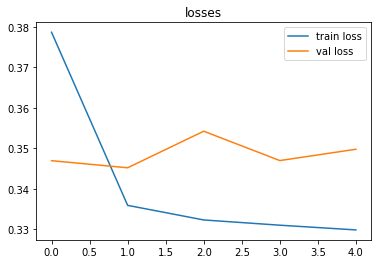

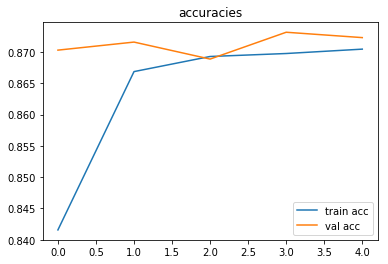

In [38]:

model = cuda(Model(num_features, hidden_layers = [], output_fcn = 'logistic'))
train(epochs = num_epochs, verbosity = 0)
visualize()

Best Loss: 0.09881731122732162
Best Acc: 0.976285714286


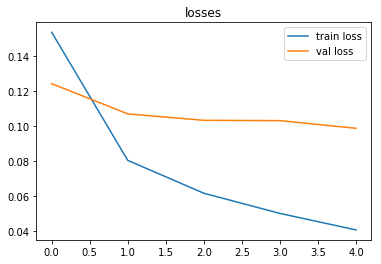

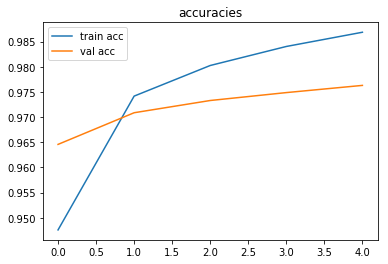

In [39]:

model = cuda(Model(num_features, hidden_layers = [100], output_fcn = 'logistic'))
train(epochs = num_epochs, verbosity = 0)
visualize()

Best Loss: 0.06607018411159515
Best Acc: 0.982285714286


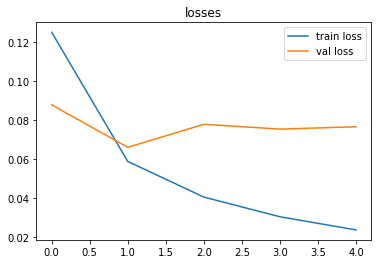

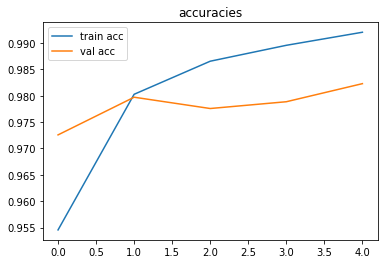

In [40]:

model = cuda(Model(num_features, hidden_layers = [100, 100], output_fcn = 'logistic'))
train(epochs = num_epochs, verbosity = 0)
visualize()

In [ ]:

model = cuda(Model(num_features, hidden_layers = [], output_fcn = 'linear'))
train(epochs = num_epochs)
visualize()

In [ ]:

model = cuda(Model(num_features, hidden_layers = [], output_fcn = 'logistic'))
train(epochs = num_epochs)
visualize()

In [ ]:

model = cuda(Model(num_features, hidden_layers = [], output_fcn = 'linear', polynomial_features = True))
train(epochs = num_epochs)
visualize()

In [ ]:

model = cuda(Model(num_features, hidden_layers = [], output_fcn = 'logistic', polynomial_features = True))
train(epochs = num_epochs)
visualize()

In [ ]:

model = cuda(Model(num_features, hidden_layers = [1000], output_fcn = 'linear'))
train(epochs=num_epochs*5)
visualize()

In [ ]:

model = cuda(Model(num_features, hidden_layers = [1000], output_fcn = 'logistic'))
train(epochs=num_epochs*5)
visualize()

In [ ]:

model = cuda(Model(num_features, hidden_layers = [100, 100], output_fcn = 'linear'))
train(epochs=num_epochs*5)
visualize()

In [ ]:

model = cuda(Model(num_features, hidden_layers = [100, 100], output_fcn = 'logistic'))
train(epochs=num_epochs*5)
visualize()

In [ ]:

model = cuda(Model(num_features, hidden_layers = [1000], output_fcn = 'logistic'))
train(epochs=num_epochs * 2)
visualize()